# In The News: Predicting Winning Political Candidates From News Tone
LT 13 | Basak, Chua, Danao, Roberto

## Executive Summary

## Introduction

Predicting the future seems to be one of mankind's deepest fascinations, and why ever not? The ability to foresee future events presents a luxury of practical benefits. For one, it enables businesses to forecast sales and predict the next occurrence of equipment failure. It also allows investors to make an informed decision on which stocks to buy or which parcels of land would be most profitable for the new year. Moreover, it helps medical professionals have an idea of how long a patient would stay in the hospital based on her health records. Getting ahead gives one the necessary time to prepare or anticipate an emerging situation, and thus take prompt action to either mitigate the risk or take advantage of the opportunity.

Although the science of forecasting finds applications in many different fields, it is not a complete stranger in the spheres of politics. The United States Presidential Elections is perhaps one of the most important political events, anticipated not only by Americans but as well as the rest of the world. This phenomenal transfer of power from one leader to another could either maintain the status quo or entirely redefine the world order. Thus, there is a strong, concerted effort among researchers to get the pulse of the voters either through social weather surveys, online polls, and other predictive methods.

Marketing intelligence company IDC reports that the entire global datasphere will grow to about 175 zettabytes by 2025. With the emergence of disruptive technologies like Big Data and AI, our ability to predict future events has become more accurate than ever before. In this project, the authors explore the predictive power of Big Data in predicting election results.

## Problem Statement

With more than 321 million monthly active users in 2018, Twitter has become one of the most influential modes of digital communication. It doles out as an online platform for people to "tweet" their thoughts, ideas, and opinions about almost all topics imaginable. These, of course, include their views about politics, and by extension, their feelings towards certain political figures, however positive or negative.

Taking advantage of this trend, many groups of researchers and programmers have mined data from Twitter, among other social media channels, and use this information to gauge people's political sentiments and therefore predict election results. In fact, a relevant paper was published by BBN Technologies, an American research and development company, showing how a candidate's popularity on Twitter can be leveraged to predict the election outcome. The authors of the said publication have collected approximately 13 billion global Twitter messages and demonstrated how they can be used for predicting the results of the Venezuelan, Paraguayan and Ecuadorian Presidential election of 2013.

While online literatures abound on using Twitter analytics for "nowcasting" the results of the polls, there are very few mentions of utilizing the Global Database of Events, Language, and Tone (GDELT) when making such a political forecast, if at all. GDELT is an immensely rich pool of data, containing some trillions of rows of various types of information from different parts of the world. A more detailed explanation of GDELT is provided at the latter part of this notebook.

In this project, the authors intend to explore the potential predictive power of online news coverage with respect to the winnability of a certain political candidate. One of the motivations of this project is to devise an alternative measure to social weather surveys in gauging the sentiment of voters. Since news articles, as they should be, are technically less biased as compared to tweets or posts on social media, it may be inferred that the model would give a more reliable output.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import dask
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras import layers
from keras import models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Methods and Data Exploration

### GDELT Data

For this study, the data was accessed through the Registry of Open Data on Amazon Web Service (AWS). Coverage of the 2016 United States Presidential Election was obtained by extracting GDELT entries corresponding to the United States for the entire year of 2016. A four-way race was considered in this study to help augment the data.

The Global Database of Events, Language, and Tone (GDELT) is an initiative whose goal is to <a href='https://www.gdeltproject.org/'> “construct a catalog of human societal-scale behavior and beliefs across all countries of the world, connecting every person, organization, location, count, theme, news source, and event across the planet”</a>. Every 15 minutes, data is collected from news sources across the world along with the identities of those involved, their country, and the tone of language used in that piece of news with the corresponding time stamp per entry. The specific data accessed for this study was over 102.9 GB of data containing over 383 million entries.

Direct interface with the GDELT data was done in a separate notebook that saved the relevant data for each presidential candidate as a time series.

Below are some summary statistics for the time series of the articles obtained per candidate.

<table><tr><th>Candidate</th><th>Total articles</th><th>Standard Dev.</th></tr><tr><td>Donald Trump</td><td>30544243</td><td>66390.26</td></tr><tr><td>Hillary Clinton</td><td>14177188</td><td>35032.018</td></tr><tr><td>Gary Johnson</td><td>754727</td><td>1743.20</td></tr><tr><td>Jill Stein</td><td>385886</td><td>1930.82</td></tr></table>


### Time Series

Each time series for a candidate was saved as a pickle file from the data wrangling notebook. These files are loaded and saved as separate variables.

The files relevant to this study are the daily time series for the number of mentions and articles per candidate and the number of mentions and articles per canidate weighted by their tone.

In [43]:
with open('trump_n_mentions.pkl','rb') as f:
    trump_n_m = pickle.load(f)
with open('clinton_n_mentions.pkl','rb') as f:
    clinton_n_m = pickle.load(f)
with open('stein_n_mentions.pkl','rb') as f:
    stein_n_m = pickle.load(f)
with open('johnson_n_mentions.pkl','rb') as f:
    johnson_n_m = pickle.load(f)
mentions = {'Donald Trump':trump_n_m, 'Hillary Clinton':clinton_n_m,
            'Jill Stein':stein_n_m, 'Gary Johnson': johnson_n_m}
    
with open('trump_n_articles.pkl','rb') as f:
    trump_n_a = pickle.load(f)
with open('clinton_n_articles.pkl','rb') as f:
    clinton_n_a = pickle.load(f)
with open('stein_n_articles.pkl','rb') as f:
    stein_n_a = pickle.load(f)
with open('johnson_n_articles.pkl','rb') as f:
    johnson_n_a = pickle.load(f)
articles = {'Donald Trump':trump_n_a, 'Hillary Clinton':clinton_n_a,
            'Jill Stein':stein_n_a, 'Gary Johnson': johnson_n_a}

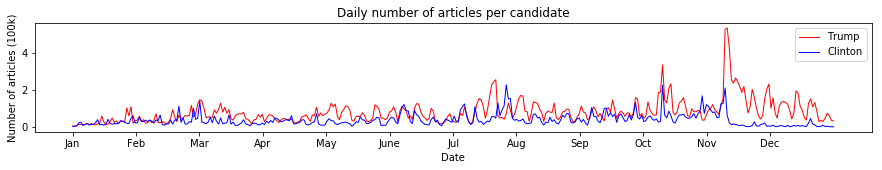

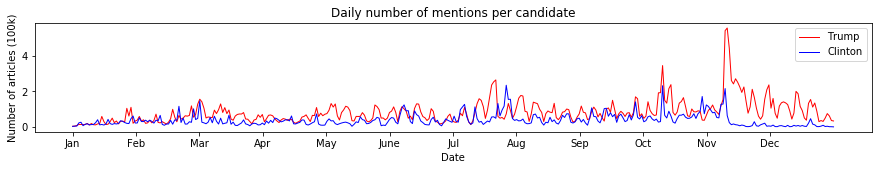

In [44]:
fig, ax = plt.subplots(figsize=(15,2))
plt.title('Daily number of articles per candidate')
plt.ylabel('Number of articles (100k)')
plt.xlabel('Date')
plt.plot(trump_n_a.values/100000, label = 'Trump', color = 'r', lw = 1)
plt.plot(clinton_n_a.values/100000, label = 'Clinton', color = 'b', lw = 1)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15,2))
plt.title('Daily number of mentions per candidate')
plt.ylabel('Number of articles (100k)')
plt.xlabel('Date')
plt.plot(trump_n_m.values/100000, label = 'Trump', color = 'r', lw = 1)
plt.plot(clinton_n_m.values/100000, label = 'Clinton', color = 'b', lw = 1)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
plt.legend()
plt.show()

It can be observed that daily number of articles and mentions per candidate have very little difference with one another suggesting that the underlying behavior for both is also similar. With the way GDELT collected and measure the number of mentions, it appears that for each article, there is approximately 1 mention for both Hillary Clinton and Donald Trump.

In [45]:
with open('trump_n_artitone.pkl','rb') as f:
    trump_n_at = pickle.load(f)
with open('clinton_n_artitone.pkl','rb') as f:
    clinton_n_at = pickle.load(f)
with open('stein_n_artitone.pkl','rb') as f:
    stein_n_at = pickle.load(f)
with open('johnson_n_artitone.pkl','rb') as f:
    johnson_n_at = pickle.load(f)
artitones = {'Donald Trump':trump_n_at, 'Hillary Clinton':clinton_n_at,
             'Jill Stein':stein_n_at, 'Gary Johnson': johnson_n_at}

    
with open('trump_n_menttone.pkl','rb') as f:
    trump_n_mt = pickle.load(f)
with open('clinton_n_menttone.pkl','rb') as f:
    clinton_n_mt = pickle.load(f)
with open('stein_n_menttone.pkl','rb') as f:
    stein_n_mt = pickle.load(f)
with open('johnson_n_menttone.pkl','rb') as f:
    johnson_n_mt = pickle.load(f)
menttones = {'Donald Trump':trump_n_mt, 'Hillary Clinton':clinton_n_mt,
             'Jill Stein':stein_n_mt, 'Gary Johnson': johnson_n_mt}

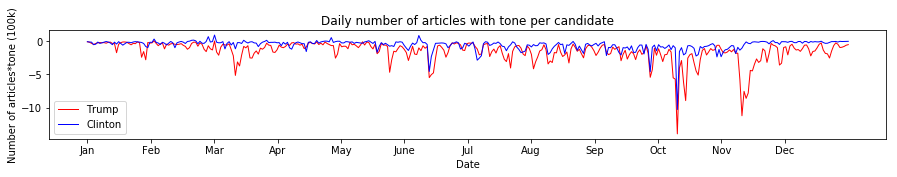

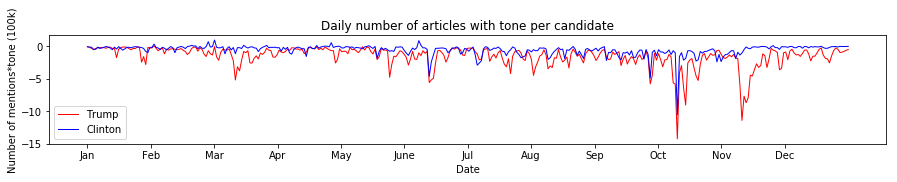

In [46]:
fig, ax = plt.subplots(figsize=(15,2))
plt.title('Daily number of articles with tone per candidate')
plt.ylabel('Number of articles*tone (100k)')
plt.xlabel('Date')
plt.plot(trump_n_at.values/100000, label = 'Trump', color = 'r', lw = 1)
plt.plot(clinton_n_at.values/100000, label = 'Clinton', color = 'b', lw = 1)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15,2))
plt.title('Daily number of articles with tone per candidate')
plt.ylabel('Number of mentions*tone (100k)')
plt.xlabel('Date')
plt.plot(trump_n_mt.values/100000, label = 'Trump', color = 'r', lw = 1)
plt.plot(clinton_n_mt.values/100000, label = 'Clinton', color = 'b', lw = 1)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
plt.legend()
plt.show()

Weighting both the number of articles and mentions by their tone failed to reveal a major difference in the time series for the two as they are still very similar with one another. Interestingly, almost all the values are overwhelmingly negative for majority of the time span covered.

### Nationwide Opinion Polling

Various organizations conduct nationwide opinion polling in the United States to gauge how well each candidate is performing during the campaign period. These results are reported by these organizations through their own channels. For this study, the results of these polls are aggregated in the Wikipedia Page entitled “Nationwide opinion polling for the 2016 United States presidential election” and is where the polling data for this study has been sourced. The results of each poll were attributed to the start of each polling period conducted by that organization. These polls are used as training data for the model leading up to the final election results.

This data was retrieved from the site as of December 1, 2019 and placed into a spreadsheet.

In [50]:
df_poll = pd.read_excel('poll_data_edit.xlsx', sheet_name='Four-way error')

In [51]:
df_poll.head()

,Poll Source,Date,Hillary Clinton,Donald Trump,Gary Johnson,Jill Stein,Leading By (Points),Sample size,Margin of error
0,YouGov/The Economist[5],20191104,0.45,0.41,0.05,0.02,4,3677.0,± 1.7%
1,Insights West[561],20191104,0.49,0.45,0.04,0.01,4,940.0,± 3.2%
2,Bloomberg News/Selzer[6],20191104,0.44,0.41,0.04,0.02,3,799.0,± 3.5%
3,Gravis Marketing[562],20191103,0.47,0.43,0.03,0.02,4,16639.0,± 0.8%
4,ABC News/Washington Post[7],20191103,0.47,0.43,0.04,0.01,4,2220.0,± 2.5%


An encoding error converted all the years to 2019 when in fact they pertain to the 2016 election. This is resolved.

In [52]:
df_poll['Date'] = df_poll['Date'].astype(str)
df_poll['Date'] = df_poll['Date'].str.replace('2019','2016')
df_poll['Date'] = df_poll['Date'].astype(int)

In [53]:
df_poll.head()

,Poll Source,Date,Hillary Clinton,Donald Trump,Gary Johnson,Jill Stein,Leading By (Points),Sample size,Margin of error
0,YouGov/The Economist[5],20161104,0.45,0.41,0.05,0.02,4,3677.0,± 1.7%
1,Insights West[561],20161104,0.49,0.45,0.04,0.01,4,940.0,± 3.2%
2,Bloomberg News/Selzer[6],20161104,0.44,0.41,0.04,0.02,3,799.0,± 3.5%
3,Gravis Marketing[562],20161103,0.47,0.43,0.03,0.02,4,16639.0,± 0.8%
4,ABC News/Washington Post[7],20161103,0.47,0.43,0.04,0.01,4,2220.0,± 2.5%


Values for each candidate represent the percentage of those surveyed that said they would vote for said candidate.

###  Time Series Slicing

Under the assumption that recent news activity has a relationship with the favorability of candidates, news measurements (`number of articles` and `number of mentions`) per candidate during the campaign period were looked at. 

Indices of the time series are harmonized to be all integers for easier slicing of the data.

In [54]:
johnson_n_m.index = [int(x) for x in johnson_n_m.index]
trump_n_m.index = [int(x) for x in trump_n_m.index]
clinton_n_m.index = [int(x) for x in clinton_n_m.index]
stein_n_m.index = [int(x) for x in stein_n_m.index]

johnson_n_a.index = [int(x) for x in johnson_n_a.index]
trump_n_a.index = [int(x) for x in trump_n_a.index]
clinton_n_a.index = [int(x) for x in clinton_n_a.index]
stein_n_a.index = [int(x) for x in stein_n_a.index]

johnson_n_mt.index = [int(x) for x in johnson_n_mt.index]
trump_n_mt.index = [int(x) for x in trump_n_mt.index]
clinton_n_mt.index = [int(x) for x in clinton_n_mt.index]
stein_n_mt.index = [int(x) for x in stein_n_mt.index]

johnson_n_at.index = [int(x) for x in johnson_n_at.index]
trump_n_at.index = [int(x) for x in trump_n_at.index]
clinton_n_at.index = [int(x) for x in clinton_n_at.index]
stein_n_at.index = [int(x) for x in stein_n_at.index]

A separate indexing is used for the dates for use in slicing the time series.

In [55]:
date_indices = list(johnson_n_m.index)

We define a helper function that takes in the name of a candidate, the type of data needed required of them, and the number of days prior to a polling period to take as input.

In [58]:
def person_df(name, ser = 'mentions', time_span = 21):
    polls_time = {}
    if ser == 'mentions':
        n_m = mentions[name]
    if ser == 'articles':
        n_m = articles[name]
    if ser == 'artitones':
        n_m = artitones[name]
    if ser == 'menttones':
        n_m = menttones[name]
    for i in range(len(df_poll)):
        poll_index = str(i) +'-'+ str(df_poll.loc[i]['Date'])
        date_index = date_indices.index(df_poll.loc[i]['Date'])
        thing = []
        for j in range(date_index-time_span, date_index):
            thing.append(n_m[date_indices[j]])
        thing.append(df_poll.loc[i][name])
        polls_time[poll_index] = thing
    df_name = pd.DataFrame(polls_time).T
    df_name.columns = list(range(time_span)) + ['target']
    return(df_name)

The resulting dataframe has rows equal to the number of nationwide opinion polls and columns equal to the number of days prior to each. Additionally, a `target` column is included which contains the poll target which is the result of the poll for that presidential candidate.

In [67]:
trump_df = person_df('Donald Trump', time_span = t_span, ser ='articles')
print(trump_df.shape)
trump_df.head()

(274, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,target
0-20161104,234529.0,80112.0,64313.0,82642.0,130800.0,139933.0,159503.0,113834.0,61339.0,57828.0,...,82606.0,89409.0,85968.0,37763.0,36828.0,64673.0,92454.0,99912.0,121350.0,0.41
1-20161104,234529.0,80112.0,64313.0,82642.0,130800.0,139933.0,159503.0,113834.0,61339.0,57828.0,...,82606.0,89409.0,85968.0,37763.0,36828.0,64673.0,92454.0,99912.0,121350.0,0.45
2-20161104,234529.0,80112.0,64313.0,82642.0,130800.0,139933.0,159503.0,113834.0,61339.0,57828.0,...,82606.0,89409.0,85968.0,37763.0,36828.0,64673.0,92454.0,99912.0,121350.0,0.41
3-20161103,210238.0,234529.0,80112.0,64313.0,82642.0,130800.0,139933.0,159503.0,113834.0,61339.0,...,83391.0,82606.0,89409.0,85968.0,37763.0,36828.0,64673.0,92454.0,99912.0,0.43
4-20161103,210238.0,234529.0,80112.0,64313.0,82642.0,130800.0,139933.0,159503.0,113834.0,61339.0,...,83391.0,82606.0,89409.0,85968.0,37763.0,36828.0,64673.0,92454.0,99912.0,0.43


A dataframe containing all the candidates is constructed.

In [60]:
t_span = 21
alls = pd.concat([person_df(x, time_span = t_span, ser ='articles') for x in
                  ['Hillary Clinton','Donald Trump',
                   'Gary Johnson','Jill Stein']])
X = alls[list(range(t_span))]
y = alls['target']

In [64]:
print(alls.shape)
alls.head()

(1096, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,target
0-20161104,60999.0,27587.0,20834.0,46526.0,64741.0,64735.0,69354.0,54654.0,47333.0,48664.0,...,46978.0,72124.0,85191.0,169281.0,73065.0,121681.0,111940.0,94286.0,78252.0,0.45
1-20161104,60999.0,27587.0,20834.0,46526.0,64741.0,64735.0,69354.0,54654.0,47333.0,48664.0,...,46978.0,72124.0,85191.0,169281.0,73065.0,121681.0,111940.0,94286.0,78252.0,0.49
2-20161104,60999.0,27587.0,20834.0,46526.0,64741.0,64735.0,69354.0,54654.0,47333.0,48664.0,...,46978.0,72124.0,85191.0,169281.0,73065.0,121681.0,111940.0,94286.0,78252.0,0.44
3-20161103,85973.0,60999.0,27587.0,20834.0,46526.0,64741.0,64735.0,69354.0,54654.0,47333.0,...,72722.0,46978.0,72124.0,85191.0,169281.0,73065.0,121681.0,111940.0,94286.0,0.47
4-20161103,85973.0,60999.0,27587.0,20834.0,46526.0,64741.0,64735.0,69354.0,54654.0,47333.0,...,72722.0,46978.0,72124.0,85191.0,169281.0,73065.0,121681.0,111940.0,94286.0,0.47


## Results and Discussion

For training, the features of the dataframe are stored as `X` while their corresponding targets are saved to `Y`. These will be used to generate training and test sets for the models.

In [ ]:
t_span = 21 #the number of days prior to a poll used as features
X = alls[list(range(t_span))]
y = alls['target']

A helper function is defined to create a simple artificial neural networks with a specified architecture to predict the results of opinion polls.

In [71]:
def neural(X, n_layers=4, n_nodes=X.shape[1], kernel='glorot_uniform',
           loss='mse', optimizer='adam', epochs=30, bias=True):
    model = models.Sequential()
    model.add(layers.Dense(
        n_nodes, input_dim=X.shape[1], activation='tanh', use_bias=bias))
    if n_layers > 1:
        for i in range(n_layers):
            model.add(layers.Dense(n_nodes, activation='tanh', use_bias=bias))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae',
                                                           'mape', 'cosine'])
    model.fit(X, np.array(y_train), epochs=epochs, verbose=0)
    y_pred = model.predict(X_test_scaled)
    return (model, r2_score(y_test, y_pred),
            mean_absolute_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred))

Variables are initiated to track and store the results of the models.

In [84]:
d_mods = []

all_accs = []
all_maes = []
all_mses = []

acc_ave = 0
mae_ave = 0
mse_ave = 0

Min-Max scaling will be performed on the training set. The scaler will then be used to transform the incoming test features when examining the performance of the model.

In [72]:
scaler = MinMaxScaler()

The training and test sets are divided into with an 80:20 ratio.

The results of the training after 100 different realizations of these splits is performed.

In [85]:
ran = 100
for q in range(ran):
    print(q, end = '\r')
    scaler = MinMaxScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                        random_state = q)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mod, acc, mae, mse = neural(X_train_scaled, n_layers = 4)
    acc_ave += acc
    mae_ave += mae
    mse_ave += mse

    all_accs.append(acc)
    all_maes.append(mae)
    all_mses.append(mse)

ave_acc = acc_ave/ran
ave_mae = mae_ave/ran
ave_mse = mse_ave/ran

The average goodness of fit is quite high at 97.165 which suggests that the model was able to explain variations in the time series well.

In [97]:
round(100*ave_acc,3)

97.165

The average MAE is shown to be 2.505 which is lower than some of the margins of error reported by the polls.

In [98]:
round(100*ave_mae,3)

2.505

A helper function is defined to test the prediction of the model on the election day itself.

In [102]:
def predictor(model, n_m,  date, time_span):
    date_index = date_indices.index(date)
    thing = []
    for j in range(date_index-time_span, date_index):
        thing.append(n_m[date_indices[j]])
    thing = scaler.transform(np.array(thing).reshape(1,-1))
    return (model.predict(thing))

In [103]:
mod.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1201 (Dense)           (None, 21)                462       
_________________________________________________________________
dense_1202 (Dense)           (None, 21)                462       
_________________________________________________________________
dense_1203 (Dense)           (None, 21)                462       
_________________________________________________________________
dense_1204 (Dense)           (None, 21)                462       
_________________________________________________________________
dense_1205 (Dense)           (None, 21)                462       
_________________________________________________________________
dense_1206 (Dense)           (None, 1)                 22        
Total params: 2,332
Trainable params: 2,332
Non-trainable params: 0
__________________________________________________

Based on the results of the 2016 United States Presidential election, we examine the model's predictions per candidate and compare them with the actual results of the election.

On the left is the model's prediction on the results on November 8, 2016 and on the right is the actual percentage of voters that voted for each candidate.

In [113]:
(round(100*predictor(mod,clinton_n_a, 20161108, 21)[0][0],2), '48.18%')

(42.46, '48.18%')

In [114]:
(round(100*predictor(mod,trump_n_a, 20161108, 21)[0][0],2), '46.09%')

(41.74, '46.09%')

In [115]:
(round(100*predictor(mod,johnson_n_a, 20161108, 21)[0][0],2),'3.28%')

(4.81, '3.28%')

In [116]:
(round(100*predictor(mod,stein_n_a, 20161108, 21)[0][0],2),'1.07%')

(4.16, '1.07%')

While the model failed to predict well the actual percentage of voters per candidate, it was still able to capture and predict the final ranking of the candidates. If the United States election were won by a simple popular vote, the model produced by this study would have been able to predict the winner. 

## Conclusion and Recommendation

There is now more data that ever before because of our increasingly interconnected world. The advent of disruptive technologies such as the Internet-of-Things (IoT) and the rise of social media platforms like Twitter and Facebook have led to a massive explosion of data, making it an almost infinite resource. Considered as the new oil, this extremely rich pool of information (more popularly known as Big Data) are now being mined, wrangled, and processed to find answers that can address a suite of business and societal challenges.

Predicting election outcomes is one problem that can be solved with data. In this report, we have demonstrated how data from news coverage can accurately predict which candidate will win the poll. However, it has to be noted that the model is not country agnostic. Meaning to say, what works for the US might not be as effective in the Philippines. This may be attributed to some factors such as difference in political dynamics, the number of media outlets present in the country, among other things.

For future work, the same approach could be experimented on different political posts such as vice president, senator, or congressman. Instead of conducting the predictive analysis on a national level, a state-wide analysis may as well be explored.

### References

https://www.gdeltproject.org  
https://registry.opendata.aws/gdelt/  
https://en.wikipedia.org/wiki/Nationwide_opinion_polling_for_the_2016_United_States_presidential_election

### Acknowledgements

We thank Sir Eduardo David Jr., Asst Prof Christian Alis, PH.D., Assoc. Prof. Erika Legara PH.D., MSDS Admin, and MSDS 2020 for the guidance and assistance in making this study possible. 